In [1]:
from TTS.api import TTS
from IPython.display import Audio
import librosa
import os

In [2]:
device="cuda"

URL : https://medium.com/@lucnguyen_61589/bring-your-voice-to-life-getting-started-with-coqui-xtts-v2-e17c9e0e5ba7

# 1. XTTS Hello World

In [3]:
# Download XTTS v2 model
tts = TTS("tts_models/multilingual/multi-dataset/xtts_v2", gpu=True)

C:\Users\admin\miniconda3\envs\tts\lib\site-packages\TTS\api.py:70: UserWarning: `gpu` will be deprecated. Please use `tts.to(device)` instead.
  warnings.warn("`gpu` will be deprecated. Please use `tts.to(device)` instead.")


 > tts_models/multilingual/multi-dataset/xtts_v2 is already downloaded.


C:\Users\admin\miniconda3\envs\tts\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 > Using model: xtts


C:\Users\admin\miniconda3\envs\tts\lib\site-packages\TTS\tts\layers\xtts\xtts_manager.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.speakers = torch.load(speaker_

## 1.1 Default speaker

In [4]:
# Generate audio with default audio
wav = tts.tts(
    "お世話になっております！はじめましてABC株式会社の田中と申します",
    speaker="Kazuhiko Atallah",
    language="ja"
)

display(Audio(wav, rate=24000))

 > Text splitted to sentences.
['お世話になっております！', 'はじめましてABC株式会社の田中と申します']
 > Processing time: 6.084274053573608
 > Real-time factor: 0.8941021731799029


## 1.2 Voice Clone

In [5]:
wav = tts.tts(
    "お世話になっております！はじめましてABC株式会社の田中と申します",
    speaker_wav=["./voice/sample.wav"],
    language="ja")

 > Text splitted to sentences.
['お世話になっております！', 'はじめましてABC株式会社の田中と申します']
 > Processing time: 5.984079360961914
 > Real-time factor: 1.1631607008921916


# II. How it works

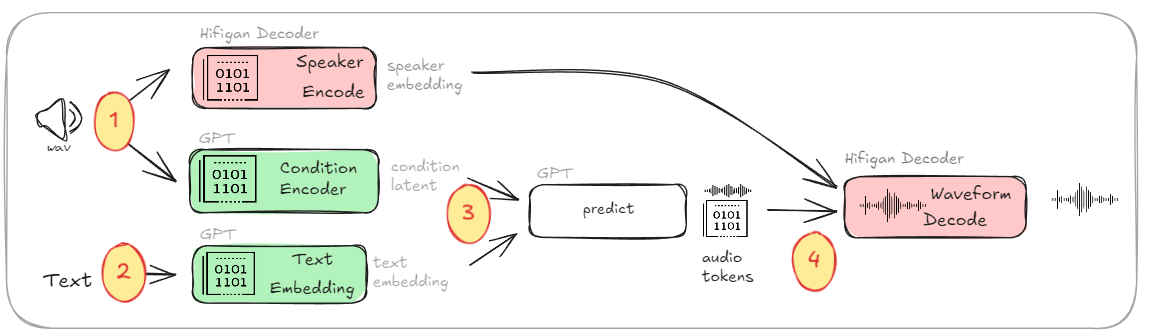

## 1. Load main components

In [6]:
import os
import torch
import torchaudio
from TTS.tts.configs.xtts_config import XttsConfig
from TTS.tts.models.xtts import Xtts
from TTS.tts.models.xtts import load_audio

**Prepare**

In [7]:
model_path = "./models/tts_models--multilingual--multi-dataset--xtts_v2"

config = XttsConfig()
config.load_json(os.path.join(model_path, "config.json"))

model = Xtts.init_from_config(config)

# Deepspeed is lib from microsoft help speed-up 
model.load_checkpoint(config, checkpoint_dir=model_path, use_deepspeed=False)
model = model.cuda()

tokenizer = model.tokenizer
gpt = model.gpt
hifigan_decoder = model.hifigan_decoder

In [8]:
tokenizer = model.tokenizer
gpt = model.gpt
hifigan_decoder = model.hifigan_decoder

In [9]:
input_text = "こんにちは！初めまして"

## 2. Step-by-Step Breakdown

### Step 1
**Extract Speaker Embedding and Conditioning Latent**

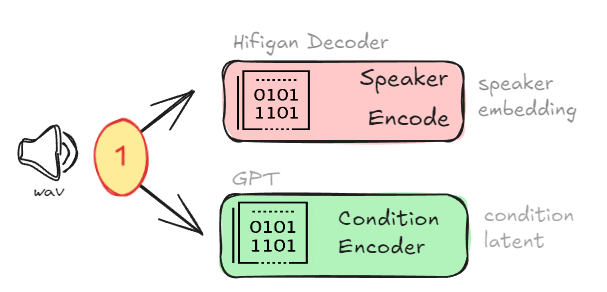

In [10]:
import torch.nn.functional as F

def get_speaker_embedding(audio_path, sr = 22050, max_ref_length = 30):
    audio = load_audio(audio_path, sampling_rate=sr)
    audio = audio[:, : sr * max_ref_length].to(device)
    audio_16k = torchaudio.functional.resample(audio, sr, 16000).to(device)

    # Get speaker embedding from speaker_encoder
    speaker_embedding = hifigan_decoder.speaker_encoder.forward(audio_16k, l2_norm=True)

    return speaker_embedding


def get_cond_lattents(audio_path, sr=22050, max_ref_length=30, gpt_cond_len=6, gpt_cond_chunk_len=6):
    audio = load_audio(reference_audio_path, sampling_rate=sr)
    audio = audio[:, : sr * max_ref_length].to(device)
    
    gpt_cond_latents = model.get_gpt_cond_latents(audio, sr, length=gpt_cond_len, chunk_length=gpt_cond_chunk_len)

    return gpt_cond_latents

In [11]:
reference_audio_path = "./voice/sample.wav"

speaker_embedding = get_speaker_embedding(reference_audio_path)
condition_latents = get_cond_lattents(reference_audio_path)

### Step 2
**Text Embedding Creation**

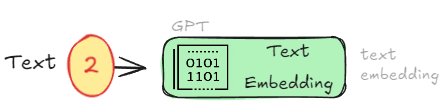

In [12]:
# Convert input text into id
text_tokens = torch.IntTensor(tokenizer.encode(input_text, lang="ja")).unsqueeze(0).to(device)
text_len = torch.tensor([text_tokens.shape[-1]], device=device)

# Padd stop and start token into text_tokens
text_inputs = F.pad(text_tokens, (0, 1), value=gpt.stop_audio_token)
text_inputs = F.pad(text_tokens, (1, 0), value=gpt.start_text_token)

# Calculate text embedding
text_embedding = gpt.text_embedding(text_inputs) + gpt.text_pos_embedding(text_inputs)

### Step 3
**Generates Audio Tokens**

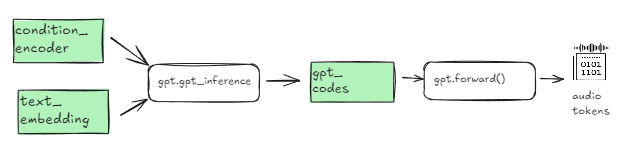

**Step 3.1**: Generate gpt_codes

In [13]:
def generate_gpt_codes(condition_latents, text_embedding):
    # Concat text embedding and condition lattents
    embedding = torch.cat([condition_latents, text_embedding], dim=1)
    
    # Create first input token for model 
    gpt_inputs = torch.full(
        (
            embedding.shape[0],
            embedding.shape[1] + 1,  # +1 for the start_audio_token
        ),
        fill_value=1,
        dtype=torch.long,
        device=device,
    )
    
    gpt_inputs[:, -1] = gpt.start_audio_token
    
    # Storage embeeding  into gpt inference
    gpt.gpt_inference.store_prefix_emb(embedding)
    
    # Generate audio tokens
    gen = gpt.gpt_inference.generate(
        gpt_inputs,
        bos_token_id=gpt.start_audio_token,
        pad_token_id=gpt.stop_audio_token,
        eos_token_id=gpt.stop_audio_token,
        max_length=gpt.max_gen_mel_tokens + gpt_inputs.shape[-1],
    )
    
    # Trim gen, remove 1 values
    gpt_codes = gen[:, gpt_inputs.shape[1] :]
    
    return gpt_codes

In [21]:
gpt_codes = generate_gpt_codes(condition_latents, text_embedding)

# gpt_codes = gpt_codes[:, :16]

In [22]:
gpt_codes.shape

torch.Size([1, 16])

**Step 3.2** Generate gpt_latents 

In [23]:
expected_output_len = torch.tensor(
    [gpt_codes.shape[-1] * gpt.code_stride_len], device=text_tokens.device
)

gpt_latents = gpt(
    text_tokens,
    text_len,
    gpt_codes,
    expected_output_len,
    cond_latents=condition_latents,
    return_attentions=False,
    return_latent=True,
)

In [24]:
gpt_latents.shape

torch.Size([1, 16, 1024])

### Step 4
**Generate waveform using Hifigan**

In [25]:
speaker_embedding = speaker_embedding.reshape(1, 512, 1)
speaker_embedding = speaker_embedding.to(device)

In [26]:
wav = hifigan_decoder(gpt_latents, g=speaker_embedding).cpu().squeeze()

In [27]:
display(
    Audio(wav.detach().cpu().numpy(), rate=22400
))